# FluentBio PBMC

> FluentBio PBMC dataset.

In [ ]:
#| default_exp fetch.pbmc

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import os, sys, json, math, pickle, warnings, itertools
import requests, tarfile, gzip, shutil

import numpy as np, pandas as pd
import torch, torch.nn as nn, pytorch_lightning as pl
import scprep, scanpy as sc, anndata as ad

import phate

import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns

In [ ]:
#| export
from dataclasses import dataclass, field, KW_ONLY

from beartype.typing import Optional, Tuple, Union, TypeAlias, Dict, Any, List, ClassVar
from nptyping import NDArray, Float, Shape, Number as AnyNumber
from beartype import beartype

#| export
from littyping.core import Device

In [ ]:
#| export
from tqdm.auto import tqdm
from kuut.core import (kuut, kstep)

In [ ]:
#| export
from iza.types import AnnData

from iza.utils import (
    drop_ext, stream_file, make_missing_dirs,
    Directory, FilterMatrixDirectory, 
    decompress_tarball_of_gunzipped_files
)

from iza.static import (
    EXT_TAR_GZ,  ADATA, MATRIX, FEATURES, BARCODES, SENSITIVITY
)
LEVEL_SENSITIVITY = 1

In [ ]:
#| export
from litds.utils import (random_split_dataframe)

## Constants

In [ ]:
#| exporti
AMAZON_BUCKET = 'https://fbs-public.s3.us-east-2.amazonaws.com'
REPORT_LINK = f'{AMAZON_BUCKET}/public-datasets/pbmc/combined.html'
FILTERED_MATRIX_LINK = f'{AMAZON_BUCKET}/public-datasets/pbmc/filtered_matrix.tar.gz'

SENSITIVITY_LEVELS = 5

SENSITIVITY_DIRS = [f'sensitivity_{i}' for i in range(1, SENSITIVITY_LEVELS + 1)]

FILTERED_MATRIX_FILES = (
    FilterMatrixDirectory.BARCODES_FILE,
    FilterMatrixDirectory.FEATURES_FILE,
    FilterMatrixDirectory.MATRIX_FILE
)

In [ ]:
#| eval: False
from iza.utils import ArchiveDownloader
from iza.static import AMAZON_BUCKET_FLUENTBIO

downloader = ArchiveDownloader(
    rootdir = AMAZON_BUCKET_FLUENTBIO,
    archive = 'public-datasets/pbmc/',
    entries = ['combined.html', 'filtered_matrix.tar.gz'],
    savedir = '~/Downloads/test',  extract=True, cleanup=True
)
downloader.execute()

Processing archive: public-datasets/pbmc/

Output()

combined.html:   0%|          | 0/30557798 [00:00<?, ?it/s]

filtered_matrix.tar.gz:   0%|          | 0/215216580 [00:00<?, ?it/s]

]8;id=51341;file:///Users/solst/Downloads/test\/Users/solst/Downloads/test]8;;\
┣━━ ]8;id=722753;file:///Users/solst/Downloads/test/filtered_matrix\filtered_matrix]8;;\ (224 bytes)
┃   ┣━━ ]8;id=832990;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_1\sensitivity_1]8;;\ (160 bytes)
┃   ┃   ┣━━ ]8;id=313246;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_1/barcodes.tsv\barcodes.tsv]8;;\ (12.8 kB)
┃   ┃   ┣━━ ]8;id=875713;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_1/features.tsv\features.tsv]8;;\ (1.4 MB)
┃   ┃   ┗━━ ]8;id=978000;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_1/matrix.mtx\matrix.mtx]8;;\ (15.6 MB)
┃   ┣━━ ]8;id=874177;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_2\sensitivity_2]8;;\ (160 bytes)
┃   ┃   ┣━━ ]8;id=97414;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_2/barcodes.tsv\barcodes.tsv]8;;\ (93.1 kB)
┃   ┃   ┣━━ ]8;id=302391;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_2/features.tsv\features.tsv]8;;\ (1.4 MB)
┃   ┃   ┗━━ ]8;id=145643;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_2/matrix.mtx\matrix.mtx]8;;\ (82.4 MB)
┃   ┣━━ ]8;id=30720;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_3\sensitivity_3]8;;\ (160 bytes)
┃   ┃   ┣━━ ]8;id=920059;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_3/barcodes.tsv\barcodes.tsv]8;;\ (267.7 kB)
┃   ┃   ┣━━ ]8;id=286870;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_3/features.tsv\features.tsv]8;;\ (1.4 MB)
┃   ┃   ┗━━ ]8;id=768027;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_3/matrix.mtx\matrix.mtx]8;;\ (190.2 MB)
┃   ┣━━ ]8;id=711801;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_4\sensitivity_4]8;;\ (160 bytes)
┃   ┃   ┣━━ ]8;id=317284;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_4/barcodes.tsv\barcodes.tsv]8;;\ (404.2 kB)
┃   ┃   ┣━━ ]8;id=442021;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_4/features.tsv\features.tsv]8;;\ (1.4 MB)
┃   ┃   ┗━━ ]8;id=755988;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_4/matrix.mtx\matrix.mtx]8;;\ (258.1 MB)
┃   ┗━━ ]8;id=145479;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_5\sensitivity_5]8;;\ (160 bytes)
┃       ┣━━ ]8;id=597200;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_5/barcodes.tsv\barcodes.tsv]8;;\ (489.8 kB)
┃       ┣━━ ]8;id=467844;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_5/features.tsv\features.tsv]8;;\ (1.4 MB)
┃       ┗━━ ]8;id=772070;file:///Users/solst/Downloads/test/filtered_matrix/sensitivity_5/matrix.mtx\matrix.mtx]8;;\ (289.1 MB)
┗━━ ]8;id=382983;file:///Users/solst/Downloads/test/combined.html\combined.html]8;;\ (30.6 MB)

## FluentBio Download

In [ ]:
#| export
@dataclass
class FluentBioPBMC2023:
    data_dir: str = os.path.expanduser('~/Downloads/fluentbio_pbmc')
 
    _: KW_ONLY
    perc_train: float = 0.7
    perc_valid: float = 0.1
    perc_test: float = 0.2

    AMAZON_BUCKET: ClassVar[str] = AMAZON_BUCKET
    REPORT_LINK: ClassVar[str] = REPORT_LINK
    FILTERED_MATRIX_LINK: ClassVar[str] = FILTERED_MATRIX_LINK
    SENSITIVITY_LEVELS: ClassVar[str] = SENSITIVITY_LEVELS
    SENSITIVITY_DIRS: ClassVar[List[str]] = SENSITIVITY_DIRS
    FILTERED_MATRIX_FILES: ClassVar[Tuple[str]] = FILTERED_MATRIX_FILES

    def __post_init__(self):
        make_missing_dirs(self.data_dir)

    @property
    def report(self):
        # NOTE: filter_matrix.tar.gz
        uri = self.REPORT_LINK
        filename = os.path.basename(uri)
        fullpath = os.path.join(self.data_dir, filename)
        return fullpath
    
    @property
    def archive_file(self):
        # NOTE: filter_matrix.tar.gz
        uri = self.FILTERED_MATRIX_LINK
        filename = os.path.basename(uri)
        fullpath = os.path.join(self.data_dir, filename)
        return fullpath
    
    @property
    def archive(self):
        # NOTE: filter_matrix        
        dirname = drop_ext(self.archive_file, EXT_TAR_GZ)
        return dirname

    @property
    def known_sensitivities(self):
        return [i for i in range(1, self.SENSITIVITY_LEVELS + 1)]

    @property
    def sensitivity_dirs(self):
        return [os.path.join(self.archive, dirname) for dirname in self.SENSITIVITY_DIRS]
    
    def int_to_sensitivity(self, i:int) -> str:
        return f'sensitivity_{i}'

    def wrangle_sensitivity(self, sensitivity:Union[str, int]) -> str:
        if isinstance(sensitivity, int):
            return self.int_to_sensitivity(sensitivity)            
        return sensitivity

    def get_sensitivity_dir(self, sensitivity:Union[str, int]) -> str:
        sensitivity = self.wrangle_sensitivity(sensitivity)
        return os.path.join(self.archive, sensitivity)

    def get_adata_filename(self, sensitivity:Union[str, int]) -> str:
        sens_dir = self.get_sensitivity_dir(sensitivity)
        sens_dir = FilterMatrixDirectory(sens_dir)
        return sens_dir.adata_filename

    def get_adata(self, sensitivity:Union[str, int]) -> AnnData:
        sens_dir = self.get_sensitivity_dir(sensitivity)
        sens_dir = FilterMatrixDirectory(sens_dir)
        return sens_dir.get_adata()

    @property
    def archive_files(self):
        return list(map(
            lambda e : os.path.join(*e),
            itertools.product(
                self.sensitivity_dirs,
                self.FILTERED_MATRIX_FILES
            ))
        )

    def print_archive_contents(self):
        print(Directory(self.archive))

    @property
    def is_archive_downloaded(self):
        return os.path.isfile(self.archive_file) or os.path.isdir(self.archive)

    @property
    def is_archive_decompressed(self):
        return all([os.path.isfile(file) for file in self.archive_files])        
    
    @property
    def is_report_downloaded(self):
        return os.path.isfile(self.report)
    

    def download(self):
        uri = self.FILTERED_MATRIX_LINK        
        description = 'Downloading FluentBio PBMC filtered matrix'  
        if not self.is_archive_downloaded:
            stream_file(uri, self.archive_file, description)

        uri = self.REPORT_LINK
        description = 'Downloading FluentBio PBMC report'
        if not self.is_report_downloaded:
            stream_file(uri, self.report, description)

    def decompress(self):
        description = 'Decompressing FluentBio PBMC filtered matrix'  
        if not self.is_archive_decompressed:
            decompress_tarball_of_gunzipped_files(self.archive_file, description, remove=True)

    def make_adata_files(self):
        desc = 'PIPSeeker Sensitivities'
        for sensitivity_dir in tqdm(self.sensitivity_dirs, desc=desc):
            try:
                fm_dir = FilterMatrixDirectory(sensitivity_dir)
            except Exception:
                pass

    def prepare(self):
        steps = [
            'Downloading', 'Decompressing',
            'Creating adata files'
        ]
        
        steps = tqdm(steps, desc='FluentBio')        
        for step in steps:
            steps.set_postfix(stage=step)
            match step:
                case 'Downloading':
                    self.download()
                case 'Decompressing':
                    self.decompress()
                case 'Creating adata files':
                    self.make_adata_files()
                case _:
                    pass
    

In [ ]:
#| eval: False
data_dir = os.path.expanduser('~/Downloads/fluentbio_pbmc')
fb_pmbc = FluentBioPBMC2023(data_dir=data_dir)

In [ ]:
#| eval: False
fb_pmbc.prepare()

FluentBio:   0%|          | 0/3 [00:00<?, ?it/s]

Decompressing FluentBio PBMC filtered matrix:   0%|          | 0/15 [00:00<?, ?it/s]

PIPSeeker Sensitivities:   0%|          | 0/5 [00:00<?, ?it/s]

sensitivity_1:   0%|          | 0/5 [00:00<?, ?it/s]

sensitivity_2:   0%|          | 0/5 [00:00<?, ?it/s]

sensitivity_3:   0%|          | 0/5 [00:00<?, ?it/s]

sensitivity_4:   0%|          | 0/5 [00:00<?, ?it/s]

sensitivity_5:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#| eval: False
adata_filename = fb_pmbc.get_adata_filename(1)
adata_filename

'/Users/solst/Downloads/fluentbio_pbmc/filtered_matrix/sensitivity_1/adata.h5'

In [ ]:
from degex.static import GENE_SYMBOL, TOTAL_COUNTS, DOUBLET_SCORES, PCT_COUNTS_MITO, PCT_COUNTS_RIBO
from degex.types import CutoffSpec, AnnData
from degex.preprocessing import (
    prepare_h5ad_file, normalization_pipeline, embedding_pipeline
)
from degex.adata import (
    stack,
    stack_batchs, calc_qc_stats,
    apply_filter_by_cutoffs,
    remove_mitochondrial_genes,
)

In [ ]:
#| eval: False
@dataclass
class PIPSeqPipeline:

    adata: AnnData

    VOIs: List[str] = field(default_factory = lambda: [
        TOTAL_COUNTS, DOUBLET_SCORES, PCT_COUNTS_MITO, PCT_COUNTS_RIBO,
        'pct_counts_in_top_50_genes', 'n_genes_by_counts', 
    ])

    def pipeline(self):
        adata_filename = fb_pmbc.get_adata_filename(1)
        adata = prepare_h5ad_file(adata_filename, plot=True)
        adata = stack_batchs(adata, idx_to_time={0: '0'})
        adata.var_names = adata.var[GENE_SYMBOL].map(lambda x: x.lower())
        adata = calc_qc_stats(adata)
        adata = apply_filter_by_cutoffs(
            adata,
            [
                CutoffSpec('total_counts', 6000, None),
                CutoffSpec('pct_counts_mito', None, 12),
            ],
        )
        sc.pp.filter_genes(adata, min_cells=5)
        adata = remove_mitochondrial_genes(adata)
        adata = normalization_pipeline(adata)
        adata, g, g_hvg = embedding_pipeline(adata, phate_kwargs=dict(n_components=3))
        sc.pl.embedding(adata, basis='X_phate_hvg', color=self.VOIs,  color_map='magma',  projection='2d', ncols=3)

/Users/solst/mambaforge/envs/litds/lib/python3.11/site-packages/degex/preprocessing.py:54: UserWarning: Failed to use sc.read_10x_h5 to load file. Using read_h5ad as fallback. Is your data from 10x?
  warnings.warn('Failed to use sc.read_10x_h5 to load file. Using read_h5ad as fallback. Is your data from 10x?')
/Users/solst/mambaforge/envs/litds/lib/python3.11/site-packages/degex/preprocessing.py:60: UserWarning: Failed to find a feature named gene_ids in adata.var. Not setting adata.names to `gene_ids`.
  warnings.warn(f'Failed to find a feature named {GENE_IDS} in adata.var. Not setting adata.names to `{GENE_IDS}`.')


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.48
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 27.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.4%
Elapsed time: 0.4 seconds


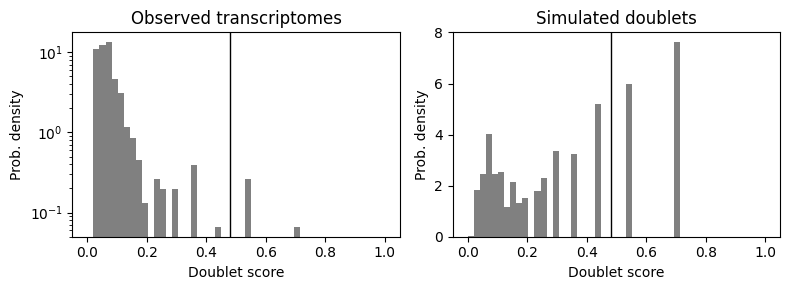

In [ ]:
#| eval: False
adata = prepare_h5ad_file(adata_filename, plot=True)

In [ ]:
#| eval: False
adata = stack_batchs(adata, idx_to_time={0: '0'})

In [ ]:
#| eval: False
adata.var_names = adata.var[GENE_SYMBOL].map(lambda x: x.lower())
adata = calc_qc_stats(adata)

/Users/solst/mambaforge/envs/litds/lib/python3.11/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['mir1302-2hg', 'fam138a', 'or4f5', 'ensg00000238009', 'ensg00000239945']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


In [ ]:
#| eval: False
adata = apply_filter_by_cutoffs(
    adata,
    [
        CutoffSpec('total_counts', 6000, None),
        CutoffSpec('pct_counts_mito', None, 12),
    ],
)

In [ ]:
#| eval: False
sc.pp.filter_genes(adata, min_cells=5)

/Users/solst/mambaforge/envs/litds/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number
/Users/solst/mambaforge/envs/litds/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/solst/mambaforge/envs/litds/lib/python3.11/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
#| eval: False
adata = remove_mitochondrial_genes(adata)

In [ ]:
#| eval: False
adata = normalization_pipeline(adata)

In [ ]:
#| eval: False
adata

AnnData object with n_obs × n_vars = 697 × 14721
    obs: 'barcodes', 'doublet_scores', 'predicted_doublets', 'batch', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'log10_total_counts'
    var: 'ensembl_id', 'gene_symbol', 'feature_type', 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    layers: 'X_prenorm', 'X_detected', 'X_scaled_normalized'

In [ ]:
#| eval: False
adata, g, g_hvg = embedding_pipeline(adata, phate_kwargs=dict(n_components=3))

g is None. Will attempt to calculate with PCA stored in adata.obsm[X_pca].
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 697 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 22
  Calculated optimal t in 0.57 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.07 seconds.
  Calculating metric MDS...


/Users/solst/mambaforge/envs/litds/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 4.82 seconds.
Calculated PHATE in 5.46 seconds.
Unique HVGs after 0 1472
g is None. Will attempt to calculate with PCA stored in adata.obsm[X_pca_hvg].
Calculating PHATE...
  Running PHATE on precomputed affinity matrix with 697 observations.
  Calculating graph and diffusion operator...
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 0.54 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.05 seconds.
  Calculating metric MDS...


/Users/solst/mambaforge/envs/litds/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 1.21 seconds.
Calculated PHATE in 1.81 seconds.
Running MAGIC on 697 cells and 14721 genes.
Using precomputed graph and diffusion operator...
Running MAGIC with `solver='exact'` on 14721-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
Calculating imputation...
Calculated imputation in 0.08 seconds.


In [ ]:
#| eval: False
VOIs=[
    'total_counts',     
    'pct_counts_in_top_50_genes', 'n_genes_by_counts', 
    'doublet_scores',
    'pct_counts_mito', 'pct_counts_ribo', 
]

In [ ]:
#| eval: False
from degex.static import X_PHATE_HVG, X_MAGIC, PHATE
cnt_name = X_MAGIC
emb_name = X_PHATE_HVG

sdata = adata[:, adata.var.highly_variable]

cnt = sdata.layers.get(cnt_name).toarray()
emb = sdata.obsm.get(emb_name).toarray()
cols = sdata.var.index
idxs = sdata.obs.index

df_cnt = pd.DataFrame(cnt, columns=cols, index=idxs)

cols = [f'{emb_name.lstrip("X_")}_{i+1}' for i in range(emb.shape[1])]
df_emb = pd.DataFrame(emb, columns=cols, index=idxs)

In [ ]:
#| eval: False
df_cnt.head()

gene_symbol,isg15,gnb1,rere,pik3cd,agtrap,tnfrsf1b,efhd2,padi4,cda,eif4g3,...,il13ra1,slc25a5,rpl39,linc00892,ssr4,flna,rpl10,mpp1,clic2,rps4y1
AAAAAAACAATCAGAT_0,0.957378,0.294748,0.107589,0.140570,0.279239,0.183727,0.331831,0.168567,0.045929,0.084642,...,0.001213,0.947998,6.351082,0.110191,2.071757,0.241934,10.670548,0.186908,0.000057,3.097314
AAAAAAAGAACGACGG_0,1.107854,0.285111,0.124548,0.122919,0.230465,0.103635,0.075606,0.111803,0.009918,0.059655,...,0.000263,1.005910,6.761696,0.123707,1.800857,0.162650,10.806679,0.120281,0.000004,3.228887
AAAAAAGTCACGACGT_0,1.476772,0.457318,0.235872,0.099159,0.206784,0.257489,0.440155,0.113485,0.007028,0.287381,...,0.285703,1.842255,5.521695,0.000070,1.999713,0.281156,9.131121,0.203138,0.618453,2.353567
AAAAACAGCCTGCCAG_0,1.385912,0.919432,0.468220,0.588342,0.690492,1.813156,1.007898,0.005735,0.215029,0.281430,...,0.027218,1.305310,4.929475,0.000215,1.678912,1.192142,7.902301,0.491415,0.081210,2.290485
AAAAACATACCTCCAC_0,1.011974,1.139733,0.377973,0.292885,0.452209,0.392202,1.103582,0.108519,0.010808,0.496587,...,0.751345,1.684636,5.692120,0.002473,1.978108,0.678499,8.486462,0.516365,0.717310,2.089748


In [ ]:
#| eval: False
df_emb.head()

,phate_hvg_1,phate_hvg_2,phate_hvg_3
AAAAAAACAATCAGAT_0,-0.032928,-0.007924,-0.000224
AAAAAAAGAACGACGG_0,-0.033991,-0.007011,0.001658
AAAAAAGTCACGACGT_0,0.039489,0.002069,-0.003020
AAAAACAGCCTGCCAG_0,0.002532,-0.020714,0.012382
AAAAACATACCTCCAC_0,0.035336,-0.002975,-0.004587


In [ ]:
#| eval: False
adata.layers.get('X_magic')

<697x14721 sparse matrix of type '<class 'numpy.float64'>'
	with 9927437 stored elements in Compressed Sparse Row format>

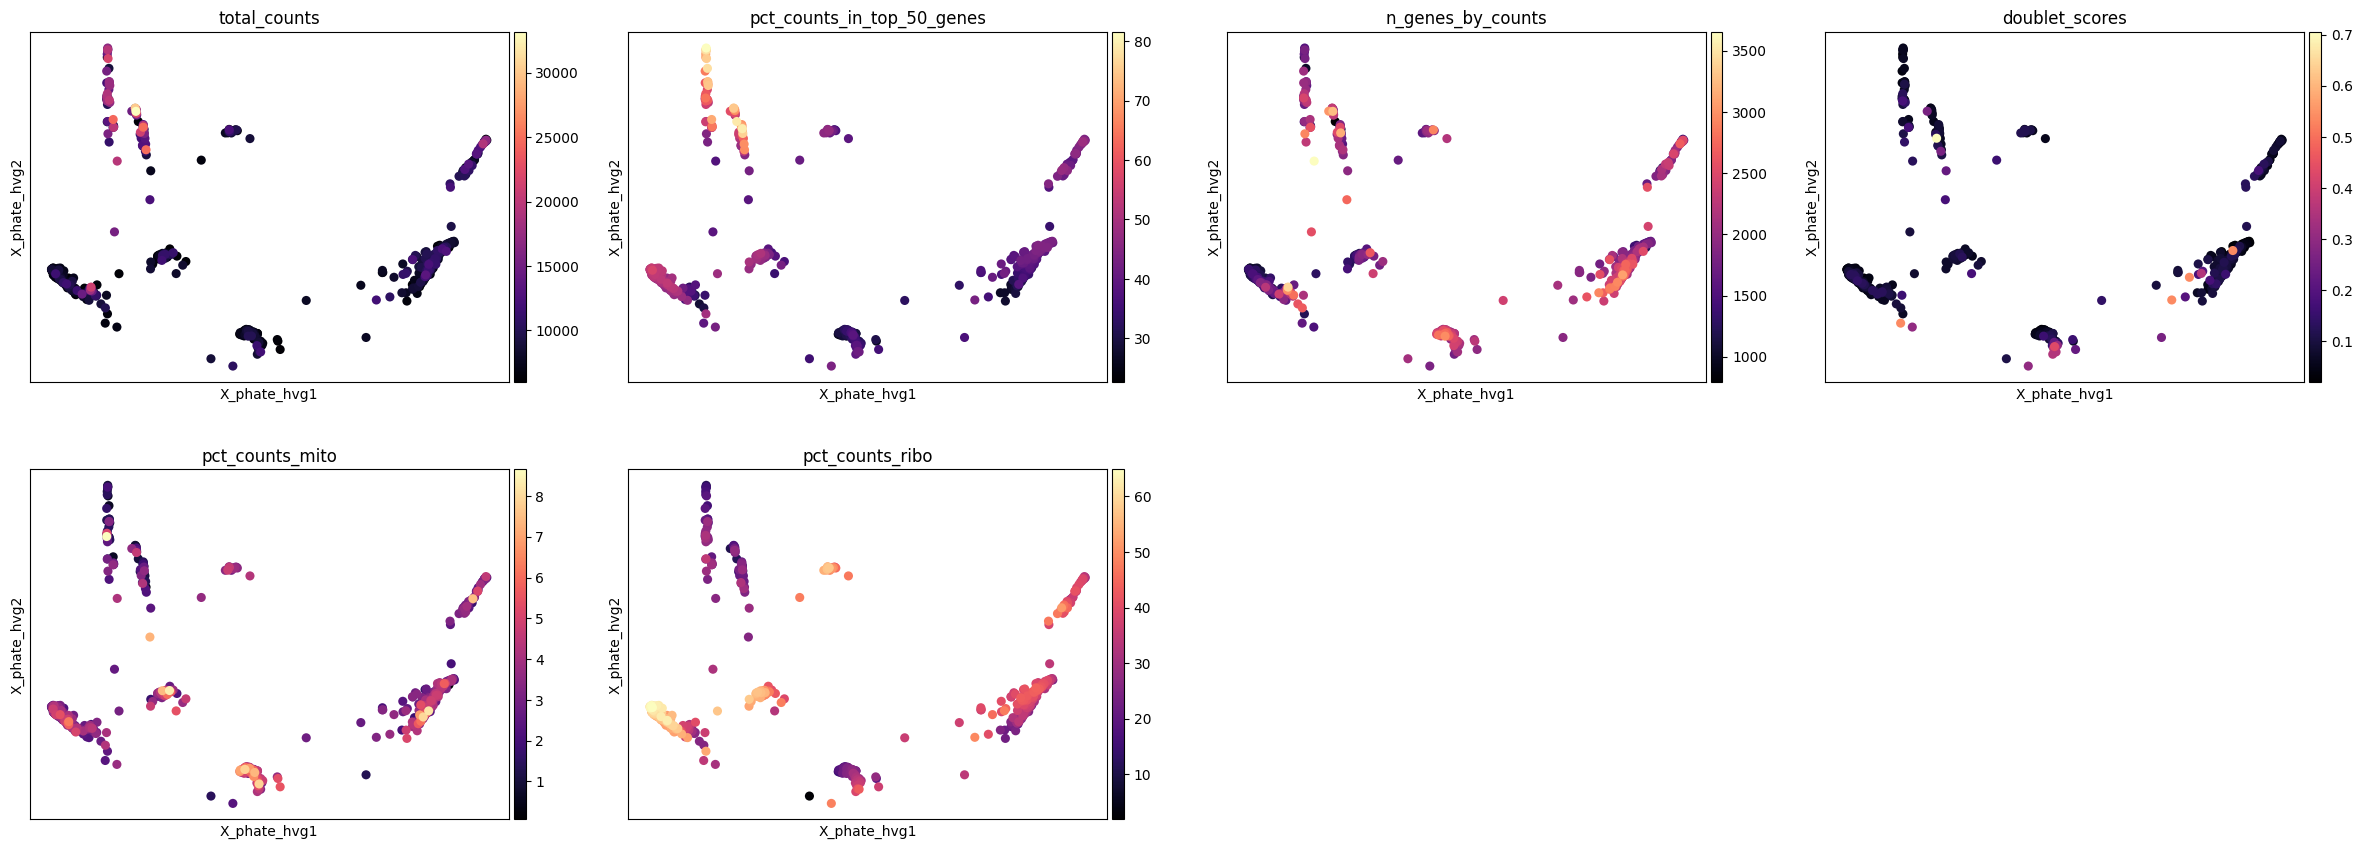

In [ ]:
#| eval: False
sc.pl.embedding(adata, basis='X_phate_hvg', color=VOIs,  color_map='magma',  projection='2d')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()